# Exercises

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
sns.set_theme(context='notebook',style='white',font_scale=1.5, #sets the stage for seaborn,plots
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet}) #axes, color map
from scipy.signal import butter
from scipy.signal import sosfilt

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle`
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Try and fix a central frequency and play with the width of the band, then try to change the central frequency of the band.
- Try to change the order of the filter, for a fixed frequency band. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic commeand [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
# Exercise 1
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp'] #1 sec = 1k
lfp2=lfp[:5000]
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')


Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Text(0, 0.5, 'voltage (mV)')

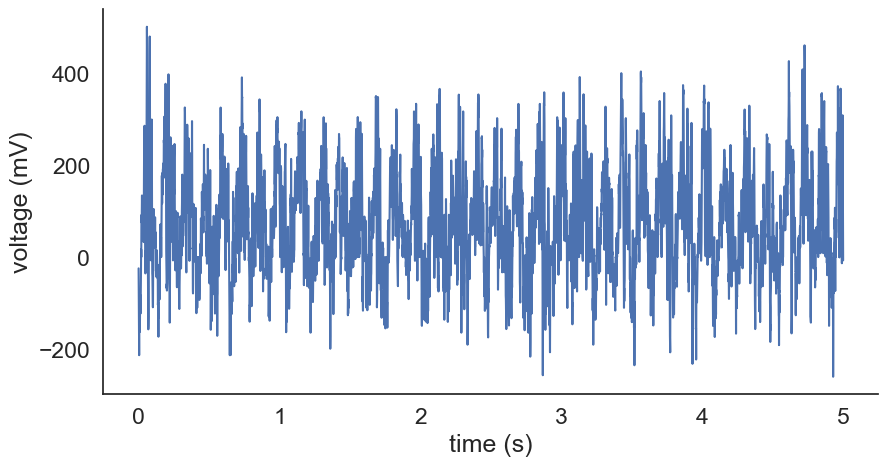

In [3]:
#Plotting the first 5 secs
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,5,5000),lfp2)
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')

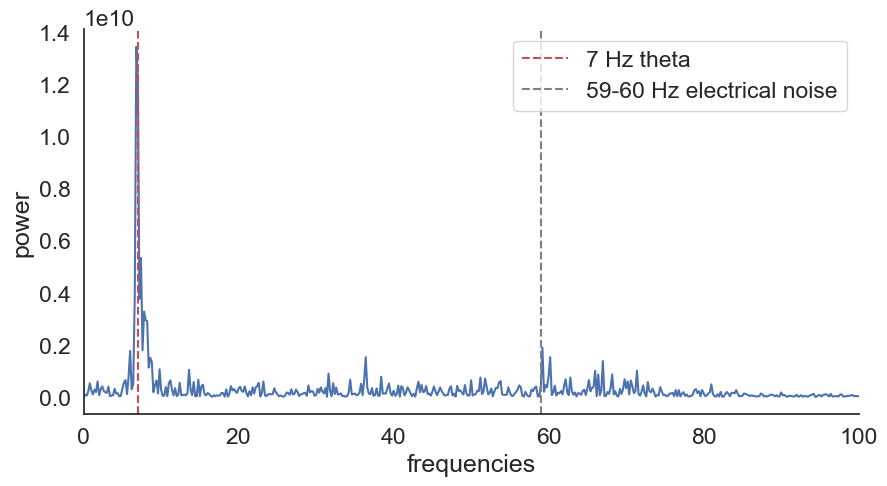

In [4]:
#Fourier Transform
from scipy.fft import fft, fftfreq 

n_samples = len(lfp2)
sample_dt = 1. / sampling_rate


centered_lfp2 = lfp2 - np.mean(lfp2)

transformed_signal = fft(centered_lfp2) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100])  
plt.xlabel('frequencies')
plt.ylabel('power')
plt.axvline(x=7 ,c='r',linestyle='--',label='7 Hz theta')
plt.axvline(x=59 ,c='grey',linestyle='--',label='59-60 Hz electrical noise')

plt.legend()

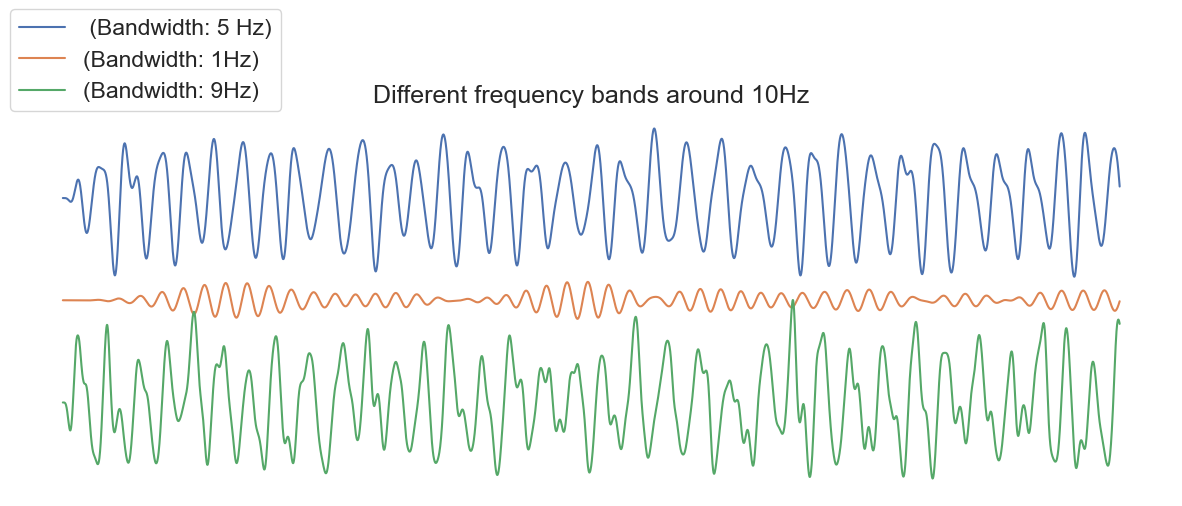

In [15]:
#Filters in different frequency bands with lf.bandpass and central frequency 10Hz

five = lf.bandpass_filter(lfp2,low_f=5,high_f=15, sampling_rate=sampling_rate)
one = lf.bandpass_filter(lfp2,low_f=9,high_f=11, sampling_rate=sampling_rate)
nine= lf.bandpass_filter(lfp2,low_f=1,high_f=19, sampling_rate=sampling_rate)

plot_offset = 200 

plt.figure(figsize=(15,5))
plt.plot(five[:5000]+2*plot_offset,label=' (Bandwidth: 5 Hz)')
plt.plot(one[:5000]+plot_offset,label = '(Bandwidth: 1Hz)')
plt.plot(nine[:5000],label = '(Bandwidth: 9Hz)')
plt.title('Different frequency bands around 10Hz')

plt.axis('off')
plt.legend(loc=(0,1))



<font color='blue'>Using a bandpass filter we filtered the signal around the same central frequency (10Hz), with different band sizes(bandwidth). Depending on what kind of information we want to extract and in which frequency ranges we select the right filter. As the bandwidth increases the spikes become noisier while when the bandwidth is too low, the signal is too suppressed and we also don't have a very clear picture. </font>

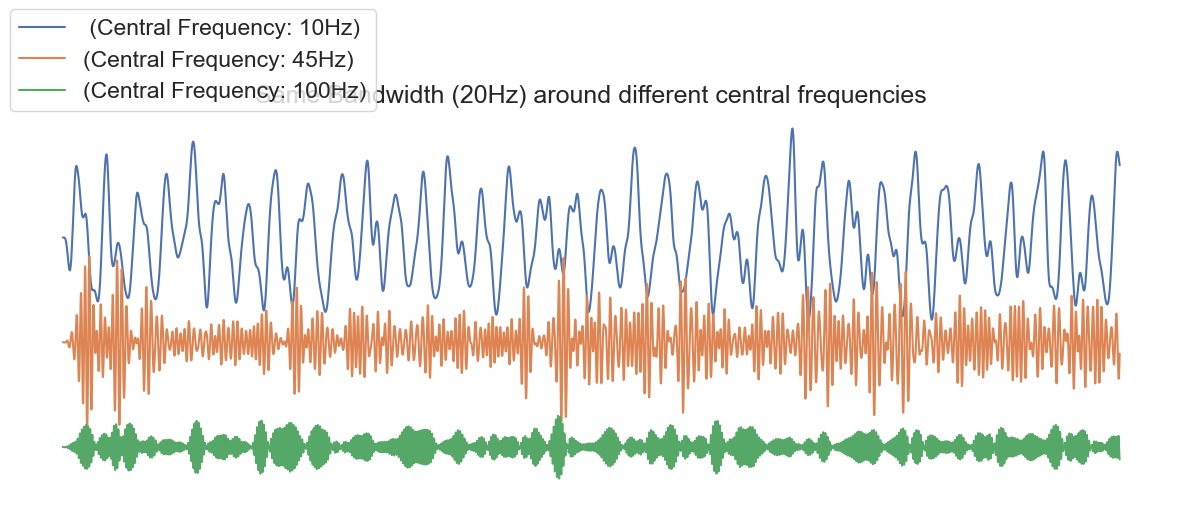

In [19]:
#Filters with same bandwidth over different central frequencies


ten = lf.bandpass_filter(lfp2,low_f=1,high_f=21, sampling_rate=sampling_rate)
fortyfive = lf.bandpass_filter(lfp2,low_f=35,high_f=55, sampling_rate=sampling_rate)
hundred= lf.bandpass_filter(lfp2,low_f=90,high_f=110, sampling_rate=sampling_rate)

plot_offset = 200 

plt.figure(figsize=(15,5))
plt.plot(ten[:5000]+2*plot_offset,label=' (Central Frequency: 10Hz)')
plt.plot(fortyfive[:5000]+plot_offset,label = '(Central Frequency: 45Hz)')
plt.plot(hundred[:5000],label = '(Central Frequency: 100Hz)')
plt.title('Same Bandwidth (20Hz) around different central frequencies')

plt.axis('off')
plt.legend(loc=(0,1))

<font color='blue'>Now, we kept the bandwidth stable at 20Hz and "moved" our filter around different central frequencies. This way we can study our range of interest without taking the whole signal into account. Of course, one would have to choose the appropriate bandwidth for best results everytime since different bands extend to different frequency ranges. Here we can sort of see the frequency around theta, slow gamma and the first part of fast gamma frequencies. The latter is too noisy to make out the spikes so we understand that our choice of bandwidth was not ideal.</font>

524 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
943 µs ± 176 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.21 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


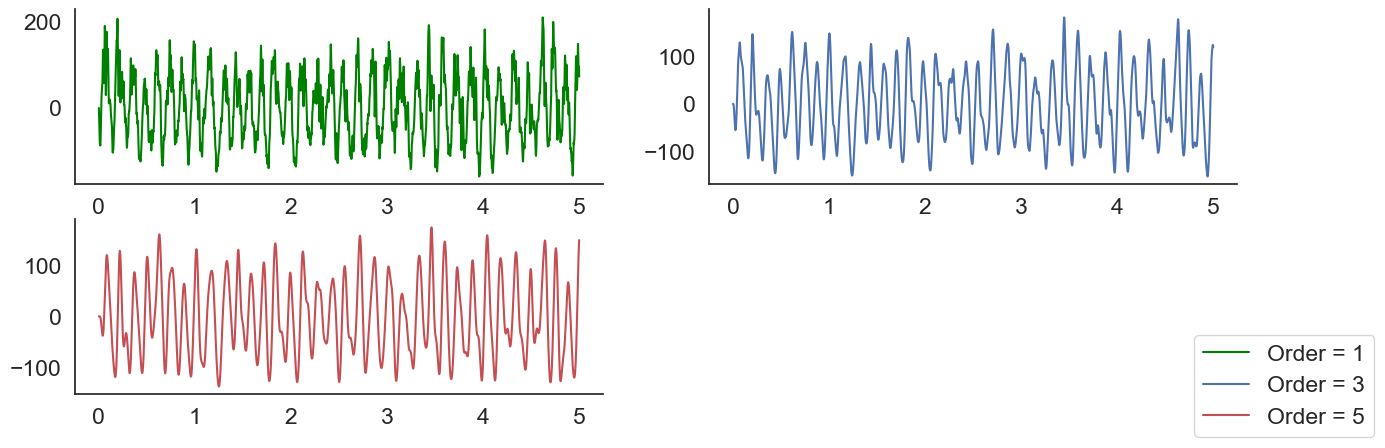

In [20]:
#Changing the order of the filter for the band: 1-15Hz 

one = 1
three = 3
five= 5
low=1
high=15
%timeit filter1 = butter(one,[low,high], btype='band', output='sos',          fs=sampling_rate)
               
%timeit  filter2=butter(three,[low,high],btype='band',    output='sos',         fs=sampling_rate)
%timeit filter3=butter(five,[low,high],      btype='band',                output='sos',                 fs=sampling_rate)
wideband1=sosfilt(filter1, lfp2)
wideband2=sosfilt(filter2, lfp2)
wideband3=sosfilt(filter3, lfp2) 


fig0=plt.figure(figsize=(15,5))
sub1= fig0.add_subplot(2,2,1)
sub2= fig0.add_subplot(2,2,2)
sub3= fig0.add_subplot(2,2,3)

sub1.plot(np.linspace(0,5,5000),wideband1,'green',label = 'Order = 1')
sub2.plot(np.linspace(0,5,5000),wideband2,label = 'Order = 3')
sub3.plot(np.linspace(0,5,5000),wideband3,'r',label = 'Order = 5')



handles=[]
labels=['Order = 1','Order = 3','Order = 5']
fig0.legend( labels, loc = ('lower right'))



<font color='blue'>We can clearly see that as the filter order increases, so does the time of computation. The filter with order 5 requires almost double the time than the first order one. As for the resolution, peaks also become more clear as the filter order increases. So it's a tradeoff between computation time and resolution. One last note is that the resolution can only get so much better and after a point the signals will have a lot of similarities or even be the same while the time will still be increasing. </font> 

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). this are all real wavelet.
- How does the spectrum look different from what we computed with a complex Morlet tranform ? Comment on why do you think this might be the case.

In [5]:
from scipy import signal
from pywt import scale2frequency
from pywt import cwt
from ipywidgets import interact
import ipywidgets as widgets

Text(0.5, 0, 'Time')

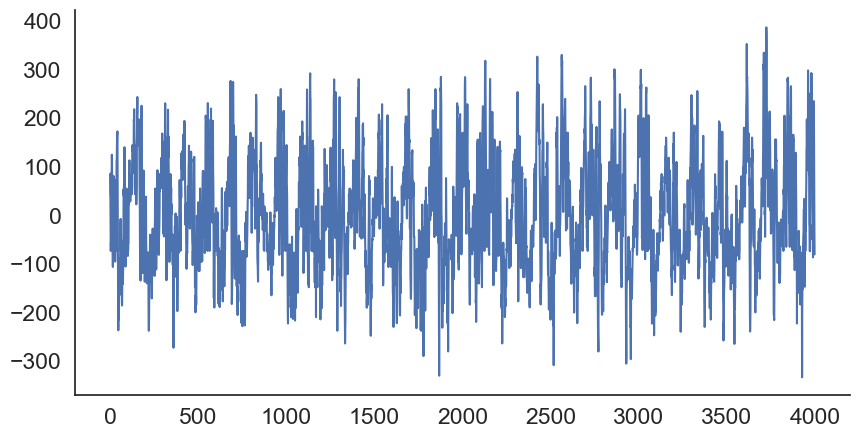

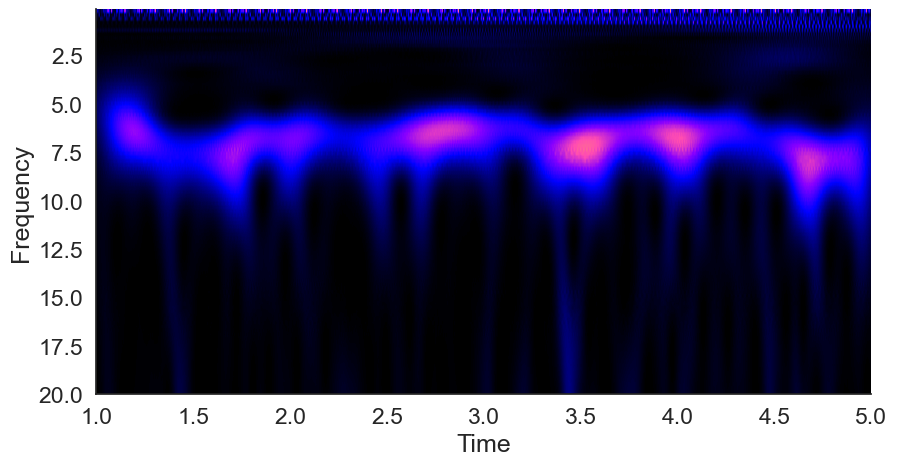

In [5]:
#Plotting the spectrogram for the first 5 seconds
#with a complex morlet transform.

start = 1
end = 5

sig = lfp2[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) 

plt.figure(figsize=(10,5))
plt.plot(sig)

frequencies =  np.linspace(0.1,20,100)/sampling_rate
wavelet ='cmor1.0-1.0' 
mexh='mexh'
gaus='gaus1'
morl='morl'

scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)



plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap=plt.cm.gnuplot2)
plt.ylabel('Frequency')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

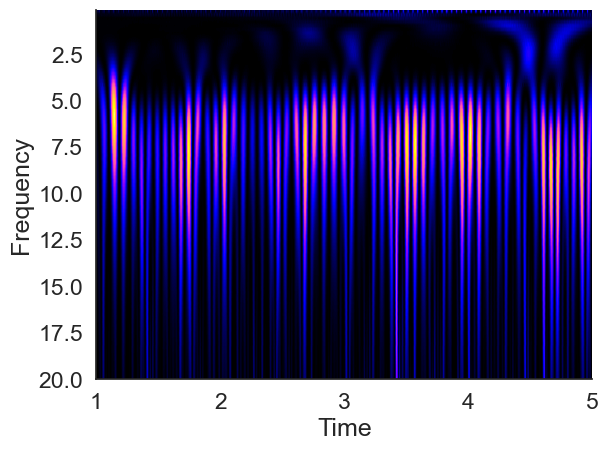

In [37]:
#Plotting the spectrogram for the first 5 seconds
#with a Mexican hat wavelet transform.

scales = scale2frequency(mexh, frequencies)
cwtmatrmh, _ = cwt(sig, wavelet=mexh, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.imshow(abs(cwtmatrmh)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap=plt.cm.gnuplot2)
plt.ylabel('Frequency')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

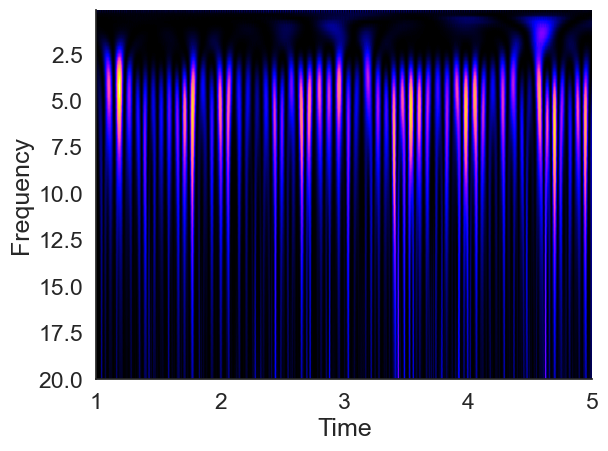

In [34]:
#Plotting the spectrogram for the first 5 seconds
#with a Gaussian wavelet transform.
scales = scale2frequency(gaus, frequencies)
cwtmatrg, _ = cwt(sig, wavelet=gaus, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.imshow(abs(cwtmatrg)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap=plt.cm.gnuplot2)
plt.ylabel('Frequency')
plt.xlabel('Time')

Text(0.5, 0, 'Time')

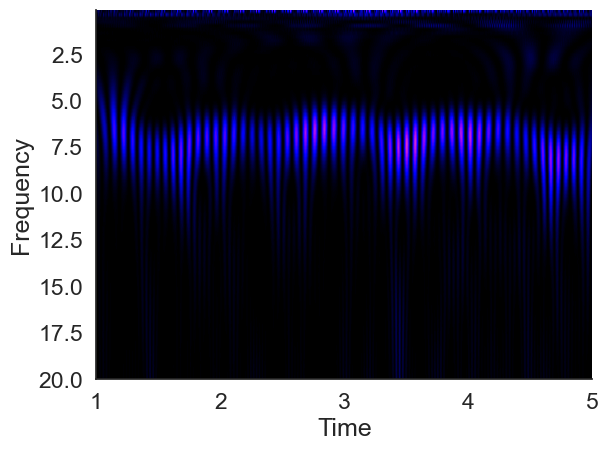

In [35]:
#Plotting the spectrogram for the first 5 seconds
#with a morlet wavelet transform.!!!It actually is only the real part of the morlet wavelet.!!!
scales = scale2frequency(morl, frequencies)
cwtmatrmr, _ = cwt(sig, wavelet=morl, scales=scales,
                  sampling_period=1.0/sampling_rate)
plt.imshow(abs(cwtmatrmr)**2, extent=[start,end,frequencies[-1]*sampling_rate,
                         frequencies[0]*sampling_rate], aspect='auto', cmap=plt.cm.gnuplot2)
plt.ylabel('Frequency')
plt.xlabel('Time')

<font color='blue'>After plotting the spectrogram with different wavelet transforms we can see a "sliced" image in all three of them. Those lines, that don't exist in the original are due to the fact that these are all real wavelets while the first one is complex. Convolution of real wavelets result in these discrete images while the convolution of a complex one results in a continuous one. This all comes from the Morlet wavelet equation which is: ψ(t)=k*e^(iωt)*e^(-t^2/2) . The complex exponential has both sin and cos (cos+ i* sin). The inclusion of the sin results in a continuous image.  </font> 

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

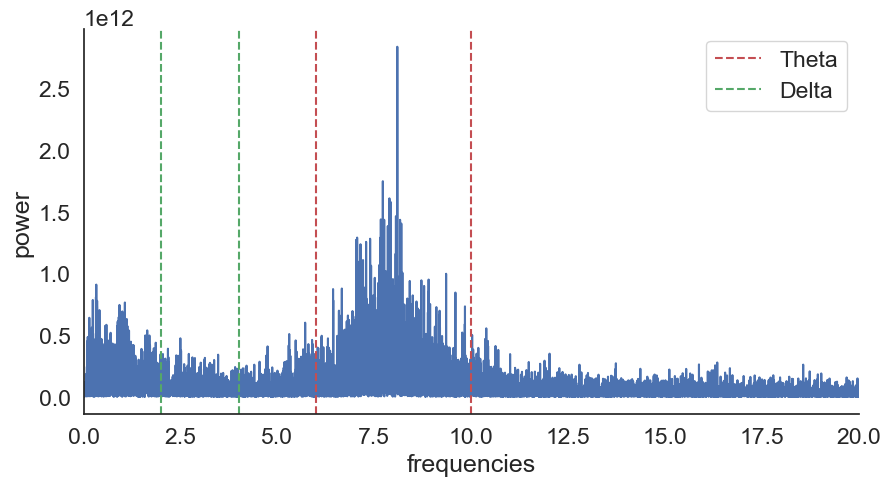

In [6]:
#Plotting the power for Delta (2-4 Hz) and Theta(6-10 Hz)
from scipy import stats
n_samples = len(lfp)
sample_dt = 1. / sampling_rate


centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,20])  
plt.xlabel('frequencies')
plt.ylabel('power')
plt.axvline(x=6 ,c='r',linestyle='--',label='Theta')
plt.axvline(x=10 ,c='r',linestyle='--')
plt.axvline(x=2 ,c='g',linestyle='--',label='Delta')
plt.axvline(x=4 ,c='g',linestyle='--')



plt.legend()



zscore= [-1.26281808 -1.23695159 -1.22532258 ... -1.24466653 -1.28615623
 -1.2884718 ]


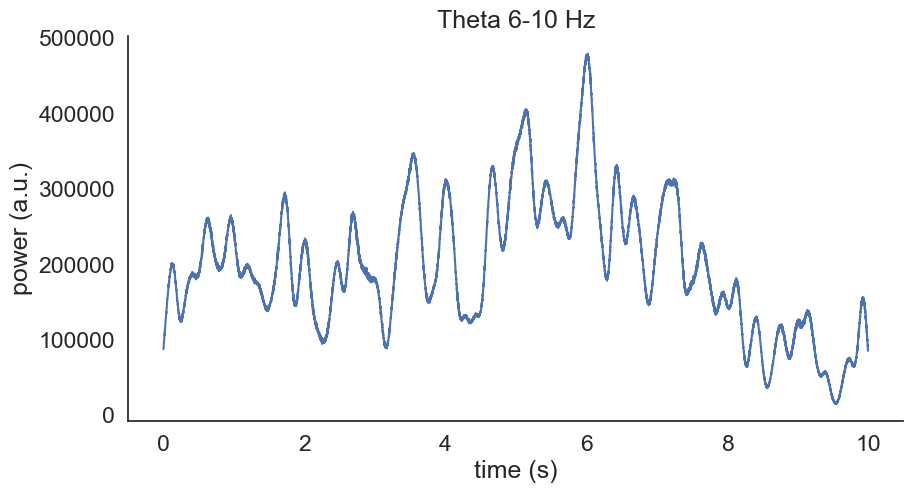

In [7]:
#Plotting the instantaneous power for Theta (6-10 Hz)
start = 0 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) 

frequencies =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

tpower = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(tpower)),tpower)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Theta 6-10 Hz')
print('zscore=',stats.zscore(tpower))


zscore= [-0.74587843 -0.72443062 -0.75902541 ...  1.37007756  1.20788593
  1.22839356]


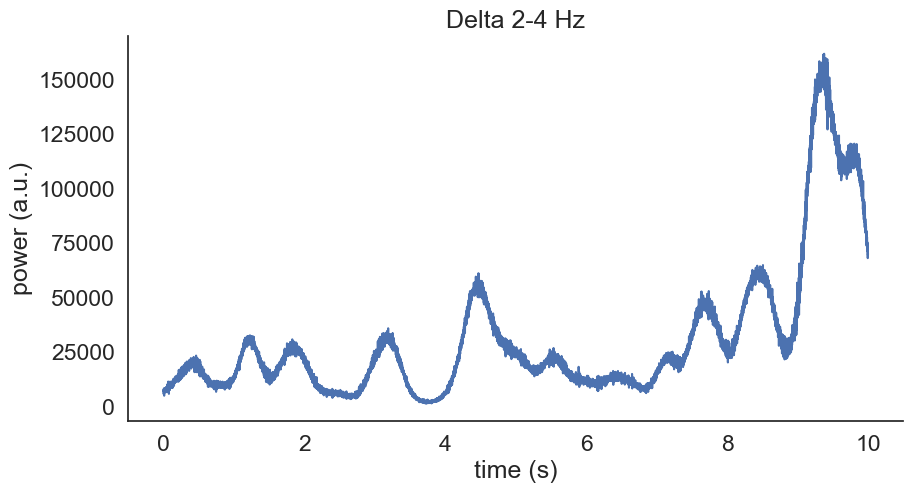

In [8]:
#Plotting the instantaneous power for Delta (2-4 Hz)
start = 0 #in seconds
end = 10 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) 

frequencies =  np.linspace(2,4,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales = scale2frequency(wavelet, frequencies)
cwtmatr, _ = cwt(sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0/sampling_rate)

dpower = np.mean(abs(cwtmatr)**2,axis=0)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(dpower)),dpower)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Delta 2-4 Hz')
print('zscore=',stats.zscore(dpower))


Text(0, 0.5, 'Power difference(a.u.)')

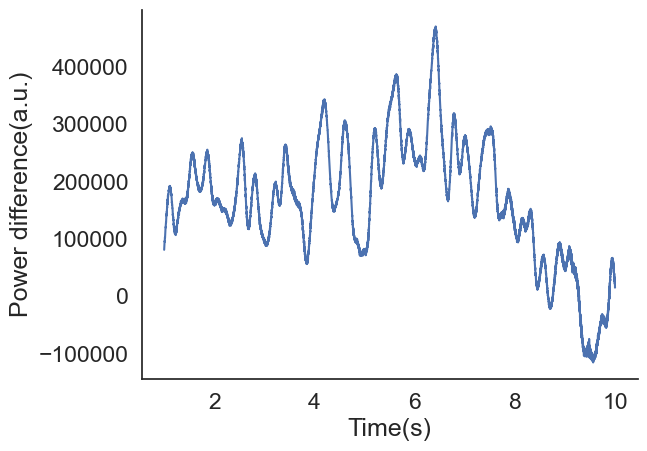

In [9]:
powdiff= tpower- dpower
dur= np.linspace(1,10,len(powdiff))
plt.plot(dur, powdiff)
plt.xlabel('Time(s)')
plt.ylabel('Power difference(a.u.)')


In [10]:
rem=[]
nrem=[]
for num in powdiff:
    if num < 200000:
        rem.append(num)
        
    if num >200000:
        nrem.append(num)
        


In [41]:
print(len(nrem), len(rem),'Does this mouse actually have REM sleep for 2/3 of its sleep time ?')


3773 6227 Does this mouse actually have REM sleep for 2/3 of its sleep time ?
